# Problem set 03C extra 

put the code of the last exercise 

In [1]:
from math import *
import matplotlib as plt
from random import gauss
import numpy as np
import bisect
from filter import *

class RobotPosition:
    def __init__(self, landmarks, world_size):
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
        self.forward_noise = 0.0;
        self.turn_noise    = 0.0;
        self.sense_noise   = 1.0;
        self.landmarks  = landmarks
        self.world_size = world_size
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= self.world_size:
            raise (ValueError, 'X coordinate out of bound')
        if new_y < 0 or new_y >= self.world_size:
            raise (ValueError, 'Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * pi:
            raise (ValueError, 'Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
    
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    
    def sense(self):
        Z = []
        for i in range(len(self.landmarks)):
            dist = sqrt((self.x - self.landmarks[i][0]) ** 2 + (self.y - self.landmarks[i][1]) ** 2)
            dist += gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    
    def move(self, turn, forward):
        if forward < 0:
            raise (ValueError, 'Robot cant move backwards')       
        
        # turn, and add randomness to the turning command
        orientation = (self.orientation + float(turn) + gauss(0.0, self.turn_noise)) % (2*pi)
        
        # move, and add randomness to the motion command
        dist = float(forward) + gauss(0.0, self.forward_noise)
        x = ( self.x + (cos(orientation) * dist) ) % self.world_size
        y = ( self.y + (sin(orientation) * dist) ) % self.world_size
        
        # set particle
        res = RobotPosition(self.landmarks, self.world_size)
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        res.landmarks = self.landmarks
        res.world_size = self.world_size
        return res
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))

def Gaussian(mu, sigma, x):
    # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
    return np.exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / np.sqrt(2.0 * pi * (sigma ** 2))


def measurement_prob(particle, measurement):

    # calculates how likely a measurement should be
    prob = 1.0;
    particlepos = particle.sense()
    sigma = np.std(measurement)
    for i in range(len(particle.landmarks)):
        pro_tem = Gaussian(particlepos[i],sigma,measurement[i]) 
        prob = prob*pro_tem
    return prob

def weighted_sample(weight_list, n_samples=None):    
    if n_samples is None:
        n_samples=len(weight_list)
    
    proba = weight_list*n_samples
    result = []
    print(proba)
    # -- TU CODIGO AQUI ---
    i=n_samples
    while i>0:
        a = random
        j = a.randint(0,len(weight_list))
        if proba[j] >0:
            result.append(j)
            proba[j]= proba[j]-1
            i-=1
    # -----
    return result

## trayectory function

In [2]:
def trayectory(n_particles, max_steps, landmarks, world_size, next_move, init_pos, plot_steps=False):
    N = n_particles

    myrobot = RobotPosition(landmarks, world_size)
    myrobot.set_noise(0.05, 0.05, 1.0)

    myrobot.x, myrobot.y = init_pos
    print (myrobot)

    robot_positions = [myrobot]

    # SE CREA UN CONJUNTO DE PARTICULAS
    p = []
    for i in range(N):
        r = RobotPosition(landmarks, world_size)
        r.set_noise(myrobot.forward_noise, myrobot.turn_noise, myrobot.sense_noise)
        p.append(r)

    if plot_steps:
        x_plots = 5
        y_plots = np.ceil((max_steps+1)*1./5)
        fig = plt.figure( figsize = (3*x_plots, 3*y_plots))
        fig.add_subplot( y_plots, x_plots, 1)
        plot_world(world_size, landmarks, robot_position=myrobot, particles=p, show_pct=0.1, no_title=True)

    errs_mean = []
    errs_std  = []
    parts_std = []
    for t in range(max_steps):
        
        # PASO 1: MOVEMOS ROBOT Y PARTICULAS DE LA MISMA MANERA
        mh, md = next_move(p)
        if mh is None or md is None:
            print ("target reached in",t,"steps")
            break
        myrobot = myrobot.move(mh, md)
        p2 = []
        for i in range(N):
            p2.append(p[i].move(mh, md))
        p = p2

        # PASO 2: OBTENEMOS LAS DISTANCIAS DEL ROBOT A LAS BALIZAS
        robot_positions.append(myrobot)
        Z = myrobot.sense()

        # PASO 3: PARA CADA PARTICULA, OBTENEMOS LA PROBABILIDAD DE OBTENER 
        #         LA MEDICION QUE OBTUVO EL ROBOT
        w = []
        for i in range(N):
            w.append(measurement_prob(p[i], Z))

        # PASO 4: MUESTREAMOS CON REEMPLAZO LAS PARTICULAS CON PROBABILIDAD
        #         PROPORCIONAL A LO OBTENIDO EN EL PASO ANTERIOR
        p3 = []
        w = w/np.sum(w)
        resample = weighted_sample(w)
        for i in resample:
            p3.append(p[i])
        p = p3

        # FINALIZACION ITERACION: MEDIMOS EL ERROR MEDIO DE LAS PARTICULAS
        # Y LA DESV ESTANDAR DE SUS POSICIONES
        er, es, stds = eval(myrobot,p, wsize)
        errs_mean.append(er)
        errs_std.append(es)
        parts_std.append(stds)
        if plot_steps:
            fig.add_subplot( y_plots, x_plots, t+2)
            plot_world(world_size, landmarks, robot_position=myrobot, particles=p, show_pct=0.1, no_title=True)
        
    print(myrobot)

    return robot_positions, p, errs_mean, errs_std, parts_std

In [9]:
import numpy as np
def move_to_target( particles ):
        
    target_point = [50,50]
    sx, sy = np.std(np.array([[p.x,p.y] for p in particles]), axis=0)
    mx, my, o = np.mean(np.array([[p.x,p.y, p.orientation] for p in particles]), axis=0)

    turn, forward = 0,0
    # calculate the angle 
    turn = -o
    x = target_point[0]-mx
    y = target_point[1]-my
    d = np.sqrt(((x**2)+(y**2))) 
    sea = y/d
    alfa = np.arcsin(sea)
    turn = turn + alfa
    forward = d
    return turn, forward

In [10]:
lmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]#, [50., 50.], [50., 20.]]
wsize = 100.0

[x=95 y=5 orient=0.8677]
[2.14699946 0.24487012 0.34511932 ... 0.32600428 7.24910312 0.01219706]
[0.00446461 0.0512126  0.04371154 ... 0.03448416 0.85464663 1.86352099]
[0.49951784 0.00457839 0.07070217 ... 0.09186545 0.01965208 0.0066563 ]
[6.79608641 0.23767988 0.09779808 ... 0.03741393 0.04364595 0.11816413]
[9.58755647e-02 2.06690415e-03 3.14990156e-02 ... 1.74643866e-03
 2.90419791e-02 2.95684507e+00]
[1.0466245  0.10930349 2.54287475 ... 0.04701123 4.42067856 0.0310796 ]
[3.19832583e-01 1.18206502e+00 8.06205807e-02 ... 3.98240028e-03
 8.58483282e-02 5.13243202e+00]
[0.97299187 0.62193867 0.02812622 ... 0.5280496  6.39380946 0.05451927]
[2.06808383e-03 9.91801104e-04 1.18054366e+00 ... 1.53305472e-02
 1.82877319e-02 6.27658803e-02]
[5.10769574e-02 1.52809686e-02 2.03601099e-01 ... 4.85030246e+00
 9.87981059e-03 3.36587170e-03]
[0.02858679 1.80997079 0.22325673 ... 0.8646533  0.0970357  0.03892892]
[1.30359026e+00 2.33624820e+00 1.03474384e-01 ... 1.03645997e-03
 2.64902917e+00 1.

[0.31103533 0.58034072 1.19716058 ... 1.09466764 1.04700899 1.20339853]
[1.71101937e+00 9.03824309e-04 1.21997422e+00 ... 1.59206682e+00
 1.66941011e+00 1.46735460e+00]
[0.72383332 1.76741411 1.77043382 ... 0.01551272 1.42726798 0.43067797]
[5.77862230e-14 2.37664407e+00 8.58256298e-02 ... 7.40955955e-01
 8.29360688e-01 5.95374798e-01]
[1.58816860e-070 1.38547293e-012 8.48935137e-027 ... 3.69767148e-010
 9.39394661e-004 8.64289934e-160]
[4.44277637e-132 4.77510601e-001 9.67219335e-032 ... 2.65243300e-071
 3.21394549e+000 8.30670374e-002]
[2.01313669 0.00637736 3.95346035 ... 1.27282402 1.52237248 0.85566066]
[0.00000000e+000 9.53136064e-002 1.45234953e-001 ... 1.60825921e+001
 2.85382832e-010 3.07026175e-246]
[2.17140506e-01 4.92162652e-02 2.08975165e-01 ... 6.87728096e-01
 4.94461632e-01 2.36115548e-09]
[5.02720984e-02 1.50036755e+00 1.97492459e+00 ... 1.55835677e+00
 4.96350872e-05 5.43986578e-09]
[1.86723143e+00 1.02304833e+00 8.37272267e-01 ... 1.89377980e-09
 7.96857114e-01 1.3720

[6.52039581e-02 1.15794928e-03 4.64931999e-01 ... 1.71396412e-01
 2.93834368e-02 2.10330875e-05]
[0.2963035  5.11437972 0.74147253 ... 0.05280901 2.30444771 0.47822454]
[5.42798414e+00 1.45504499e-07 7.37638487e-09 ... 5.30872054e-02
 1.51540439e-03 5.81950800e-09]
[1.21713776e-23 5.89893878e-14 5.62303417e-04 ... 4.84105462e-09
 5.06710880e-04 1.01726381e-11]
[8.12539999e-01 2.56265177e-04 3.85666134e+00 ... 8.78460922e-07
 1.02366143e-07 2.45242355e-07]
[1.42517246e-57 7.79195155e-16 4.09977923e-13 ... 1.56981162e-07
 5.85751314e-11 9.99454948e-43]
[3.87645838e+00 1.09872300e-02 5.99700649e-03 ... 1.40039155e-03
 4.15225613e+00 5.44516025e-01]
[1.68590728e-10 2.12271493e-01 1.00168891e-03 ... 3.01687234e-06
 1.01057408e-04 2.30617238e-08]
[1.29777607 3.47431836 1.37260136 ... 0.26004184 6.44540811 1.566419  ]
[1.42914788 0.04285973 2.73024382 ... 4.0490312  0.03917245 0.52215651]
[9.00722655e-01 8.58785028e-05 3.82264544e-02 ... 2.88083940e-09
 2.13144949e-05 4.56830958e-06]
[0.12971

[1.12530347e-02 6.61985535e+00 2.97113715e-07 ... 1.63574753e-08
 5.14453357e-11 7.54697456e-06]
[0.19489581 0.05362233 0.00753541 ... 0.12189748 4.5148799  0.01457084]
[4.45641644e-05 5.61670641e-03 6.10190865e-01 ... 4.66008818e-02
 4.93961723e-04 5.29310415e+00]
[3.51174721e+00 1.67371483e-05 3.86634371e-02 ... 6.68346327e-04
 4.17891590e-02 7.15679476e-01]
[5.99979808e-01 2.63002709e-02 3.30081087e-03 ... 2.18377854e-06
 3.19640212e-07 1.59423992e-05]
[0.01577076 0.21357602 0.01615654 ... 0.02476564 0.00038058 0.34630927]
[0.08935309 0.9986532  0.0084676  ... 0.77222019 1.65163698 0.00410033]
[7.60953463e-04 4.28765122e-06 2.62932935e-03 ... 5.86335566e-05
 3.54136412e-01 3.56058998e-03]
[1.91070997 0.27882629 0.00317226 ... 1.15249967 0.45420385 0.00496642]
[0.03385129 0.97733498 0.58279554 ... 0.01298063 0.00677594 0.08070533]
[2.06086120e-07 2.29552066e-09 1.57209071e-01 ... 1.66340218e-01
 2.82507369e-01 5.27989978e-02]
[1.50475255e+00 4.96123756e-04 6.03353446e-01 ... 5.131238

[0.59458251 0.36987329 1.11274155 ... 1.09414706 0.83640361 1.08671981]
[1.04008554 0.99809619 1.03540633 ... 1.02490485 0.95029487 1.06007571]
[1.07710698 1.03823969 1.07777611 ... 1.05077555 1.077092   1.05192454]
[1.13996537e+00 1.03333783e+00 2.04543738e-04 ... 1.13800708e+00
 1.09671271e+00 1.02281830e+00]
[1.09847361 0.87687522 1.02425982 ... 0.90063074 1.23946551 1.2004739 ]
[1.11189486 1.1118166  0.92625571 ... 0.91637696 0.78669159 1.09199471]
[1.0357184  1.08672584 0.75844313 ... 0.97021029 1.06693099 1.00287216]
[0.77789146 1.33751096 1.03391821 ... 0.69964102 1.26257055 1.03419721]
[0.34288462 1.76309258 2.16975532 ... 0.00318348 1.51076719 1.08173378]
[1.2476192  1.36744679 1.04091666 ... 1.37078364 0.32603197 1.34944325]
[1.11000213 0.877371   1.00616064 ... 1.14453027 0.94986884 0.99083677]
[1.00727189 1.0744175  1.03324125 ... 1.00909313 1.07385528 1.07134705]
[0.935125   0.9489296  0.96183106 ... 1.05761752 0.93548249 1.04993176]
[1.01623458 1.28016256 1.17565179 ... 1

[6.42840412e-14 2.60328575e-13 3.57023236e+00 ... 1.57573987e+00
 8.03710537e-05 3.51965086e-04]
[2.99285451e+00 2.01715581e-14 1.98201489e-02 ... 7.23159642e-03
 4.02252058e+00 1.42306647e+00]
[1.20165140e+00 3.50813974e+00 4.77923562e-06 ... 3.25219219e-05
 3.65969812e+00 1.91992948e-22]
[0.11625833 2.79696339 0.00464086 ... 1.42835027 1.95960779 3.58868879]
[3.01592529e-08 1.49633682e+00 1.32242026e+00 ... 1.56880256e+00
 2.11698822e-05 1.56682432e+00]
[5.12038607e-02 1.28213164e+00 1.29092970e+00 ... 1.20234393e+00
 1.15256031e+00 5.24262316e-04]
[1.1869204  0.13866395 1.15522675 ... 1.18513027 1.15341593 1.20721672]
[0.77706875 1.06794266 0.61643054 ... 1.09227089 1.14920291 1.08062386]
[1.43092955 1.54742439 0.63761056 ... 0.83156084 1.55124315 1.44942952]
[1.04415997e+00 6.62230073e-03 1.46163136e-12 ... 6.69306800e-04
 6.71445938e-01 5.38874143e-01]
[2.56062376 1.3865782  0.25625148 ... 2.60976985 3.27199973 2.38061384]
[0.97470409 2.66345868 2.17480652 ... 1.12019907 0.0611589

[9.92736281e-02 1.00781496e+00 1.07615382e-01 ... 8.36993936e-03
 1.46456680e-05 6.77037040e-01]
[1.33871085e-02 1.46429671e+00 7.19629514e-03 ... 3.39096465e+00
 2.14336131e-01 7.87657288e-05]
[1.94622727e-02 1.47194547e-11 1.01698260e-01 ... 4.77613647e-01
 5.47172375e-01 4.00914021e-04]
[9.47572963e-25 7.63662139e-13 1.81086000e-08 ... 1.58189598e-30
 2.87645948e-35 6.58041941e-12]
[1.30418828e-07 7.78577987e-10 3.57397158e-04 ... 3.76721547e-06
 2.03522813e-12 3.34589977e-04]
[5.51253208 1.60783796 0.64753557 ... 6.02016637 2.53341102 0.1571005 ]
[7.80208843e-06 8.36867982e-14 1.41453904e-05 ... 7.44211595e-05
 7.38442394e-04 6.21410831e-01]
[6.86729735e-01 2.46749254e-02 1.21302402e-03 ... 3.05513960e-02
 8.94531981e-09 8.96142158e-03]
[0.04360297 0.01624908 0.00574246 ... 0.62524532 0.19960137 1.03874573]
[1.19241863e+01 7.71648500e+00 7.68821590e-02 ... 7.64648025e-09
 7.31947724e-03 5.89366080e-09]
[2.17086133e+00 3.72151666e-02 1.36200778e-01 ... 4.34738903e-03
 7.35745518e-02

[0.00043579 0.24286269 0.02656712 ... 0.03357628 0.35389153 0.00196387]
[3.31000629e-02 3.57233865e-02 1.96109319e-04 ... 2.27497596e-03
 2.00697995e-08 6.31050045e-02]
[4.78185493e+00 2.82562008e-01 1.64971578e+00 ... 9.43242435e-02
 2.34612662e-03 3.68275066e-02]
[0.56986222 0.55777995 1.61436201 ... 2.85718284 0.18733271 0.15437319]
[0.65764911 1.39260596 0.16858807 ... 0.3004715  0.08306307 0.88597465]
[0.80270593 0.86988359 3.18735515 ... 1.44221658 3.5363553  0.22685589]
[3.50447183e-09 2.68423857e-03 1.47529451e-09 ... 6.86445341e-05
 2.80501879e-13 7.83973712e-07]
[0.96876475 2.86690741 0.01990199 ... 1.40803876 0.31114219 0.1799689 ]
[3.10213786e-068 7.74358637e-077 3.43990877e-048 ... 6.06027773e-031
 3.14097320e-123 1.66968915e-112]
[0.00383796 0.02825966 0.00293817 ... 0.18376656 0.0573095  0.5465181 ]
[2.05350113e+00 3.34766050e-04 3.53668362e-07 ... 1.50553443e-08
 1.30765958e+00 1.25576842e-05]
[2.80581121e-01 9.03370951e-03 4.35504743e-03 ... 1.44997141e-02
 7.42902094e

[0.06740777 0.02439533 1.47412941 ... 0.1005187  1.15220339 1.05961946]
[2.330353   0.02421044 0.44650752 ... 1.13159974 0.08208827 1.14360246]
[0.81225877 1.03511692 1.04600895 ... 0.81301108 1.01130987 0.88236619]
[1.15859035 1.21873682 1.01923248 ... 0.98185165 1.17406788 0.99585234]
[1.09002678 0.99423628 0.8437785  ... 0.58413403 1.10181036 1.0333601 ]
[1.15755796 1.14109204 0.96774273 ... 1.14648439 0.88084451 1.15742956]
[1.01455873 1.05052761 0.94452441 ... 0.98948382 1.06377696 1.01721149]
[0.82651368 1.05407232 1.10299221 ... 1.1371171  0.78445311 1.07553501]
[0.98199999 0.80292153 1.03906073 ... 1.0105704  1.10669136 1.11054873]
[0.93942145 1.11603896 1.2197416  ... 1.08979256 1.23860364 1.21866238]
[0.7576589  1.29182047 1.207868   ... 0.20534195 1.13019833 1.29350894]
[1.06290281 0.96348368 1.07962232 ... 0.93009345 1.08836927 1.12501448]
[0.73709517 1.12607921 1.08115353 ... 0.97218721 1.03115385 1.13884366]
[1.00116877 1.08372887 0.96187671 ... 0.75393498 1.02493788 0.91

[0.33727399 0.19271833 0.30301379 ... 0.2146408  0.08772797 0.00574241]
[1.78087825e-05 6.37290214e-06 7.95773176e-02 ... 1.46829279e+01
 2.08578161e-08 5.57035771e-02]
[0.96302548 0.16452236 1.80277339 ... 0.03508879 2.50412661 1.92535185]
[1.01011174 0.01514428 0.21269348 ... 2.64294077 0.84903189 0.92015048]
[1.56859669 0.6609684  1.40504666 ... 1.30256751 0.32661025 0.05647487]
[1.81277668 1.32528761 0.46286565 ... 1.6670616  1.79223692 1.20401129]
[0.83732629 0.96387841 0.66683591 ... 0.74766716 1.27355796 1.44160107]
[1.27211636 0.85778295 1.26257235 ... 1.24587063 0.83708121 0.82593958]
[0.4635024  0.52855042 1.27322352 ... 1.34888321 1.2105925  0.25546328]
[2.11601721e-06 1.03656528e-04 5.97922143e-06 ... 5.53705829e-02
 6.79929682e-07 8.76831409e-06]
[8.25621688e-01 2.42943594e-04 3.63310000e+00 ... 2.50022578e-01
 1.53802247e-01 2.41851622e+00]
[0.10135135 0.07009617 2.87886131 ... 0.51303579 0.01274594 1.37067653]
[0.34887485 0.35529766 0.00683206 ... 5.99385625 1.19898283 0

[0.02214375 0.00699429 5.39773516 ... 2.71401439 0.71289707 0.44013396]
[5.15218896e-138 3.03053164e-001 2.31645043e-001 ... 3.10795695e-007
 1.59970246e-003 3.80559107e-005]
[1.88199480e-04 1.92151678e-02 4.22015985e+00 ... 7.91193588e-03
 3.09254312e-04 4.14647906e-01]
[1.06062051e-03 1.24849917e-06 5.43704289e-11 ... 4.65699008e-12
 1.50660037e-05 3.42524201e-05]
[4.12787734 4.83986721 2.955838   ... 1.45243399 0.60531813 0.41840365]
[3.82107769e-05 6.76182139e-02 3.48195540e-02 ... 5.35252300e-01
 1.42140975e-02 1.09356925e-01]
[1.20932547e-06 3.25221568e-02 2.63960164e-02 ... 2.43417152e+00
 2.94872529e-02 5.33947584e-02]
[0.47616443 2.02926889 1.23531014 ... 0.46336545 1.73715605 0.34123005]
[8.92411938e-06 1.88110415e-08 1.25066031e-01 ... 2.84185685e-07
 5.94147594e-22 9.82116797e-08]
[0.01670166 1.25382129 0.17193615 ... 6.29242743 1.46829932 4.7307396 ]
[1.50948576e+01 1.25177093e-02 1.01745987e-01 ... 8.76093101e-04
 2.68488724e-02 7.37035131e-01]
[0.00070131 0.01274236 0.00

<Figure size 432x288 with 0 Axes>

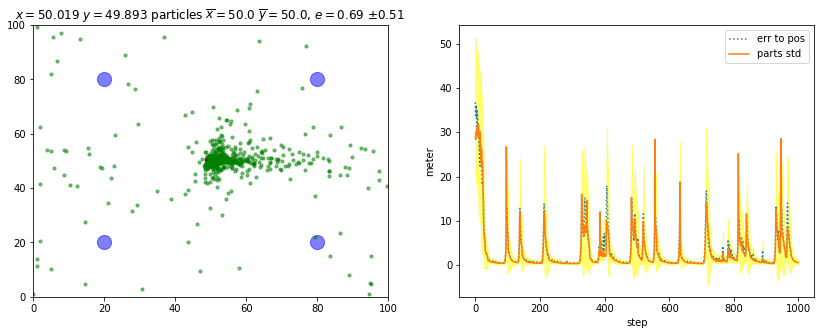

In [11]:

robot_positions, particles, errs_mean, errs_std, parts_std = trayectory(n_particles=2000, max_steps=1000, 
                                                                        landmarks=lmarks, world_size=wsize,
                                                                        next_move=move_to_target, 
                                                                        init_pos = [95,5])
plt.figure()
plot_all(wsize, lmarks, robot_positions, particles, errs_mean, errs_std, parts_std)

to other point

In [12]:
import numpy as np
def move_to_target( particles ):
        
    target_point = [10,50]
    sx, sy = np.std(np.array([[p.x,p.y] for p in particles]), axis=0)
    mx, my, o = np.mean(np.array([[p.x,p.y, p.orientation] for p in particles]), axis=0)

    turn, forward = 0,0
    # calculate the angle 
    turn = -o
    x = target_point[0]-mx
    y = target_point[1]-my
    d = np.sqrt(((x**2)+(y**2))) 
    sea = y/d
    alfa = np.arcsin(sea)
    turn = turn + alfa
    forward = d
    return turn, forward

[x=95 y=5 orient=3.1139]
[0.17327172 0.20541716 0.00515895 ... 0.26426418 0.05966909 0.00656509]
[3.01677982 0.02726215 0.18794703 ... 1.10033481 1.01230731 0.00516626]
[5.63466138e-03 4.01172566e+00 1.62275766e-03 ... 2.31050895e-01
 2.26415378e-01 1.45208753e-02]
[0.18891784 0.01261608 0.07448283 ... 0.15413756 0.11109766 0.04942798]
[0.00760757 0.05267452 0.0041731  ... 0.22848048 2.24985805 0.00393923]
[0.03751213 0.02004902 0.01162244 ... 0.07176816 0.78560736 0.00464224]
[0.05983821 0.78156844 0.00977095 ... 0.00672979 0.01125848 0.00842769]
[1.00022736 3.49780899 0.04247278 ... 2.5011415  0.00475021 0.68183973]
[0.75639592 0.71333693 0.06730818 ... 1.91574681 1.7189053  0.03674261]
[0.15178488 3.15476998 0.01134592 ... 0.01213414 2.51996951 2.82220206]
[3.27394542e+00 1.26592336e-02 3.77453841e-04 ... 1.98693468e-02
 3.96738256e+00 1.18425707e-01]
[1.07003524e+00 2.05723048e+00 1.99603406e-03 ... 5.43768960e-02
 2.02698429e+00 2.38784269e-01]
[4.45439921e-03 3.25675724e+00 1.708

[1.00316135 1.00550297 1.00510855 ... 1.00562519 1.00272327 1.00625702]
[1.00201346 0.98540067 1.00330999 ... 0.95955999 0.97005631 0.99966325]
[1.00535567 0.99705648 1.00077347 ... 1.00440394 0.99712539 0.9992822 ]
[0.99881059 1.00483758 1.00388799 ... 0.99832689 0.99965835 0.99818655]
[1.00297879 0.99603348 1.0033321  ... 1.00257552 1.00729814 1.00348116]
[0.99632872 1.00186736 1.00556399 ... 1.00264461 0.99187185 0.99924442]
[1.00686632 1.00273022 1.00140318 ... 0.99194403 1.00481125 1.00109811]
[1.00288446 0.99807174 0.99149245 ... 1.00560081 1.00136269 0.99869064]
[1.00267067 1.00034676 1.01105299 ... 1.01121802 0.9987711  1.00363509]
[0.98255626 0.98870577 0.99029277 ... 0.99589862 1.00688307 1.00533125]
[1.00601065 1.00168872 1.00418159 ... 1.00518241 1.00262226 1.00498313]
[1.00275226 1.00212414 0.99737583 ... 1.0049283  0.98722407 1.00419216]
[1.00026571 1.00839473 0.99844542 ... 1.0075379  1.00482601 1.0045535 ]
[1.00250432 1.00740329 0.99623068 ... 1.00797934 1.0051633  0.99

[1.40315071 1.20301095 1.09993137 ... 0.07214591 0.51609694 0.06065137]
[4.90847557e-05 8.02438791e-01 2.01294869e-02 ... 1.05825995e+00
 1.78882629e+00 1.11956453e+00]
[1.40658357e+00 2.25044219e+00 1.91473692e-10 ... 2.43555345e+00
 1.08380896e-01 2.37149512e-01]
[1.84459893e+00 1.04242426e+00 1.37682421e+00 ... 1.41729640e-03
 1.51505534e+00 3.94571844e-04]
[5.29575772e-02 1.79410557e+00 7.24835645e-02 ... 3.82348567e-02
 2.18198184e+00 1.57081365e-04]
[2.55126446e+00 2.00587605e-03 2.09482525e+00 ... 2.04165247e-03
 7.13262784e-04 1.01314378e+00]
[1.55326666e-01 2.75073218e-02 1.96928207e+00 ... 7.03634560e-01
 3.31660866e+00 6.37181081e-07]
[1.45070371e+00 4.17242357e-05 4.78961226e-01 ... 2.12500711e+00
 4.11038760e+00 3.92414545e+00]
[1.5822855  0.38186472 0.01143832 ... 1.323644   1.46234998 1.23891406]
[0.63630537 0.05689235 1.05322679 ... 1.99792391 1.12431648 1.62118578]
[1.72241153e-03 4.02528420e-01 2.20555296e-02 ... 1.96850155e+00
 1.95538929e+00 1.97603341e+00]
[0.04192

[1.27309276 0.07525628 1.41148077 ... 0.10732697 0.39156885 0.01905583]
[1.41580731 0.93297536 1.22558499 ... 0.78092059 1.45440533 1.07956751]
[1.0012443  1.25984534 0.01875565 ... 1.17809255 0.01524006 1.2876699 ]
[0.74939999 0.28698215 1.47947601 ... 1.5591943  0.68899242 1.46332155]
[2.35271929e-10 1.00114255e-01 4.33126250e-08 ... 4.03210074e-02
 3.67639356e-10 1.30261560e-01]
[7.76923626e-03 1.81173202e+00 1.65639241e+00 ... 1.08187779e-03
 1.71136709e+00 1.62053693e+00]
[0.64987036 0.00301982 1.25668767 ... 1.08917508 0.98891885 1.22386768]
[1.67998303 0.48580805 0.97277677 ... 1.90170636 3.50530258 0.6747875 ]
[0.77933752 1.07109093 1.00884375 ... 1.18745354 0.55853126 0.40959723]
[0.01557526 0.12153077 0.00547228 ... 0.0106091  0.01984613 0.00437031]
[5.76128291e-01 3.64077135e-04 1.56294863e+00 ... 2.00249267e+00
 1.99775515e+00 1.91447871e+00]
[3.76389141 0.30639458 0.20994652 ... 0.00985789 1.67360849 3.8806203 ]
[2.52412348e+00 2.62343494e+00 1.43533756e-03 ... 2.63010172e

[1.41826380e-03 2.71093016e-03 1.18004772e+00 ... 1.93469387e-05
 6.80734637e-03 7.81078146e-01]
[5.20190051e-01 2.22977358e+00 2.08787088e+00 ... 2.13541315e+00
 2.09545992e+00 4.80463467e-04]
[0.17734431 0.00380614 0.2666391  ... 0.94008124 0.28208348 0.45827408]
[2.82990598e+00 3.48678076e-06 3.36999632e-03 ... 7.16062927e-08
 1.20181108e+00 2.99997300e+00]
[1.67149348 1.70478702 1.66407242 ... 1.27889499 1.44074946 1.43942394]
[2.15372995 2.04630883 1.92266513 ... 1.38074211 0.0198179  2.10873885]
[1.50223525 1.28429437 1.14314048 ... 0.001876   1.34018456 1.65489811]
[1.05882671 1.36748589 1.04719049 ... 1.51024585 1.43836807 1.46772159]
[1.43440580e+00 6.68404468e-01 4.24798745e-04 ... 2.73543005e-01
 1.49569406e+00 1.23243588e+00]
[1.44769186e-03 1.26530408e-01 1.41742456e+00 ... 1.32414272e+00
 1.64298830e+00 8.50460671e-02]
[4.91359681e-05 4.29989805e-71 6.94446874e-12 ... 7.15517559e+00
 5.09036796e-32 3.01870840e-07]
[0.00496004 0.00197109 0.99608575 ... 1.24572118 1.2938590

[2.31731580e+00 5.42289723e-06 3.69630629e+00 ... 1.87703432e-10
 1.91690436e-51 1.35713127e+00]
[1.70176681e+00 5.38570355e-04 5.45528200e-01 ... 2.22721848e-04
 1.69629160e+00 1.71722893e+00]
[2.56408537e+00 2.28577620e+00 2.28725482e+00 ... 2.39724180e+00
 1.79927235e-03 1.11667749e-03]
[8.16117190e-03 1.90682886e+00 3.94671108e-04 ... 1.84233134e+00
 1.70316257e+00 1.91328428e+00]
[0.00227311 2.17769791 0.00710922 ... 2.16190349 2.14400469 0.00328189]
[0.31150787 0.44907181 1.09459122 ... 0.44279329 2.06314527 0.93518897]
[6.56921059e-01 2.36312090e+00 2.11096114e-07 ... 1.92654273e+00
 1.47359680e-08 5.90564898e-05]
[0.11823827 0.09716971 0.15134307 ... 1.73091943 0.10307745 0.93684548]
[1.37673409e-05 4.02176561e-02 2.89388448e-05 ... 1.78279676e-01
 3.48385001e-01 5.86533172e-02]
[1.14691937 1.51542837 0.10880913 ... 1.48293633 1.56816699 0.93811761]
[0.34745157 1.12238842 0.16094263 ... 0.31974389 0.80459609 0.88638372]
[1.21240772 1.40622796 1.13704445 ... 1.5919303  1.4560760

[0.97952263 1.02137944 1.025046   ... 0.99062776 1.01664641 1.01254893]
[0.95479423 1.03877041 1.13640869 ... 0.93825424 1.032179   0.90868174]
[1.00259564 0.97594897 1.01983662 ... 1.0132307  1.01605126 1.02382651]
[0.9944656  1.00309384 0.96501677 ... 1.01992785 1.01325974 1.0009954 ]
[1.01502679 1.01296424 0.98980977 ... 1.00973621 0.98283447 1.00748033]
[0.99700742 0.95455798 1.0145392  ... 0.9989378  0.9975809  1.00745698]
[0.9680713  0.98409529 1.01842903 ... 0.99986496 0.96509225 1.01622079]
[0.98893052 0.9949259  0.99971632 ... 1.0193028  1.01708168 0.99566764]
[1.00283619 1.00812707 1.00261009 ... 1.01053632 0.97295731 1.00975658]
[1.00835599 1.00193813 0.99327504 ... 0.95732765 0.99351324 1.00635714]
[1.00606766 1.00713907 1.01198846 ... 0.99931077 0.98372046 1.02163056]
[0.75582791 0.99570359 0.7444417  ... 1.06683133 1.00108058 1.05260558]
[3.09593959 1.7190533  1.75637151 ... 2.15820575 1.30006448 0.29008249]
[1.47888718 1.44790895 0.88507392 ... 1.37100964 0.20218467 0.18

[5.55965023e-01 2.26377205e+00 1.38967218e+00 ... 7.22281127e-01
 1.88317341e+00 2.49232311e-05]
[0.34857716 0.26963339 1.3348875  ... 0.09650795 0.01594395 0.02050782]
[1.01625589 0.96431439 0.82649893 ... 0.59604922 0.94496692 1.09911479]
[0.63544986 1.30362171 1.214477   ... 0.77606907 1.05422107 1.09537125]
[0.40709598 0.00830955 0.11447553 ... 0.30799945 0.32465512 1.03424617]
[1.08430051 1.12976442 1.11775055 ... 1.09092531 0.92596615 1.02974073]
[0.7319352  0.99485141 0.86194092 ... 1.11033571 1.00060104 0.82040488]
[0.94587352 0.59226153 1.08434471 ... 0.95689787 0.81468982 1.05196412]
[1.06854526 0.85386993 1.04779188 ... 0.99103493 1.02222781 0.98773646]
[0.97488905 1.03103327 1.02300058 ... 1.01323091 1.04799908 1.00499193]
[1.00238956 1.06194443 1.04367476 ... 1.02860499 0.93581062 1.02824083]
[0.98803155 1.0178117  0.9169856  ... 1.0446913  0.98905512 1.02847582]
[0.99777143 1.04394788 0.97968197 ... 0.98032333 0.93109195 1.02277825]
[1.03170176 0.9101613  1.0473321  ... 1

[0.99398988 0.99575597 0.9582042  ... 1.00723295 0.99284753 1.01963194]
[1.01903836 1.01201466 0.98368875 ... 1.00428064 1.01608661 1.0074657 ]
[0.9892667  1.01783275 0.98835188 ... 0.97022518 0.99999224 1.00376275]
[0.98938281 1.01388615 1.00796699 ... 0.99136394 1.01665993 1.01119173]
[0.99932671 0.97420588 1.00513008 ... 1.00007831 1.00708263 0.99883014]
[1.00232161 0.99935347 0.99983323 ... 0.99825184 1.0018431  0.98406281]
[1.01061507 0.99444251 1.00468032 ... 0.98487986 1.00204641 1.01202612]
[0.9943429  0.99273775 1.00081336 ... 0.98075433 1.0019097  1.00755267]
[1.00504961 0.99935072 0.99373403 ... 1.00460207 1.01252771 0.99464204]
[1.01129468 0.99738804 1.01328307 ... 1.00035596 1.00315244 1.00222484]
[0.99897921 1.00254586 1.00279594 ... 0.99662305 1.00985389 0.99942913]
[0.99097773 1.00878449 0.98150008 ... 1.00688086 0.98290508 0.99768159]
[1.00484005 0.99111445 0.93632131 ... 1.00767681 1.00721729 1.0092501 ]
[0.99465585 1.01649093 0.97336423 ... 0.99862432 0.98291059 1.00

[0.8896993  1.02468798 1.03639524 ... 0.98352948 0.84513904 1.00585427]
[1.01260415 1.00498758 1.02739663 ... 1.02565201 1.02707484 0.9554052 ]
[1.00073836 1.02441    1.02382253 ... 1.0236493  0.97188578 1.01349194]
[0.98375386 1.01359376 1.0193461  ... 1.02777286 0.98895726 1.0259396 ]
[1.00591016 1.01810487 0.99749326 ... 0.96499502 1.00614504 0.99980038]
[1.01045914 1.02091559 0.97296399 ... 0.99887272 0.9926248  1.00335769]
[1.00463855 1.0100994  1.01489069 ... 1.0253251  1.02207081 1.00451539]
[1.01635567 0.99354732 1.01475216 ... 1.02239011 1.00451632 1.01454262]
[0.98514317 1.00491887 1.01140453 ... 1.00666552 1.0177324  1.00786213]
[0.98592403 0.79798369 1.01112193 ... 1.00596329 0.99958685 1.0120383 ]
[1.00718814 1.00406062 0.97637752 ... 1.01069636 0.99975615 0.99439993]
[1.00303935 1.01097453 1.00962299 ... 0.96703649 1.00867327 0.97667788]
[0.97921041 1.00958748 1.00970102 ... 1.00920689 1.01895358 0.95544678]
[1.00745165 0.98690032 1.0057146  ... 0.98960445 0.99573986 1.01

<Figure size 432x288 with 0 Axes>

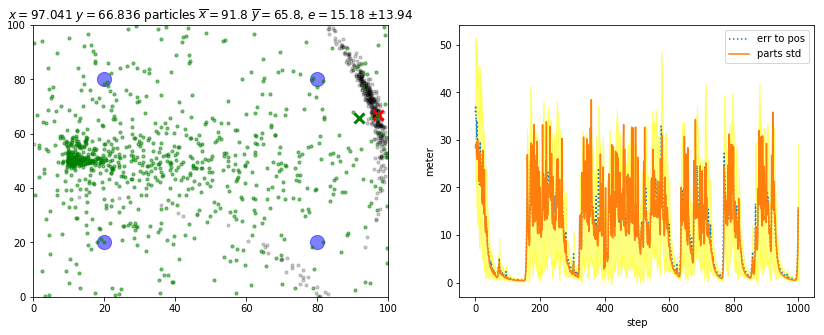

In [13]:
robot_positions, particles, errs_mean, errs_std, parts_std = trayectory(n_particles=2000, max_steps=1000, 
                                                                        landmarks=lmarks, world_size=wsize,
                                                                        next_move=move_to_target, 
                                                                        init_pos = [95,5])
plt.figure()
plot_all(wsize, lmarks, robot_positions, particles, errs_mean, errs_std, parts_std)

#### End
##### thanks